In [1]:
import pandas as p
import numpy as n
import seaborn as s
import matplotlib.pyplot as py
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer,PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.utils import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [103]:
# nltk.download('stopwords')

In [104]:
tweet_test = p.read_csv('test_df.csv',encoding='ISO-8859-1',index_col=False)
tweet_train = p.read_csv('train.csv',encoding='ISO-8859-1',index_col=False)

In [105]:
tweet_test.head(2)

,Unnamed: 0,textID,text,sentiment
0,1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
1,2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative


In [106]:
tweet_train.head(2)

,Unnamed: 0,textID,text,selected_text,sentiment
0,1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
1,2,088c60f138,my boss is bullying me...,bullying me,negative


In [107]:
print(tweet_train.shape)
print(tweet_test.shape)

(16363, 5)
(2104, 4)


In [108]:
tweet_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16363 entries, 0 to 16362
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     16363 non-null  int64 
 1   textID         16363 non-null  object
 2   text           16363 non-null  object
 3   selected_text  16363 non-null  object
 4   sentiment      16363 non-null  object
dtypes: int64(1), object(4)
memory usage: 639.3+ KB


# DATA CLEANING

In [109]:
tweet_train.drop(['Unnamed: 0','textID','selected_text'],inplace=True,axis=1)

In [110]:
tweet_test.drop(['Unnamed: 0','textID'],inplace=True,axis=1)

In [111]:
tweet_train.isna().sum()

text         0
sentiment    0
dtype: int64

In [112]:
tweet_test.isna().sum()

text         0
sentiment    0
dtype: int64

In [113]:
tweet_train.groupby('sentiment').count()

,text
sentiment,
negative,7781
positive,8582


In [114]:
tweet_test.groupby('sentiment').count()

,text
sentiment,
negative,1001
positive,1103


# EDA

In [115]:
tweet_train['text_length'] = tweet_train['text'].apply(lambda x:len(str(x)))

In [116]:
tweet_test['text_length'] = tweet_test['text'].apply(lambda x:len(str(x)))

In [117]:
def countplot(df):
#     py.figure(figsize=(10,3))
    s.countplot(data=df,x='sentiment')

In [118]:
def kdeplot(df):
#     py.figure(figsize=(10,2))
    s.kdeplot(data=df,hue='sentiment',x='text_length',palette='deep')
    py.ylabel('')
#     py.xlim(0)

In [119]:
def boxplot(df):
    print(df.groupby('sentiment').describe())
    s.boxplot(data=df,x='sentiment',y='text_length')

          text_length                                                    
                count       mean        std  min   25%   50%   75%    max
sentiment                                                                
negative       7781.0  70.551729  35.226499  5.0  42.0  66.0  98.0  171.0
positive       8582.0  70.474015  34.699448  5.0  42.0  67.0  98.0  149.0


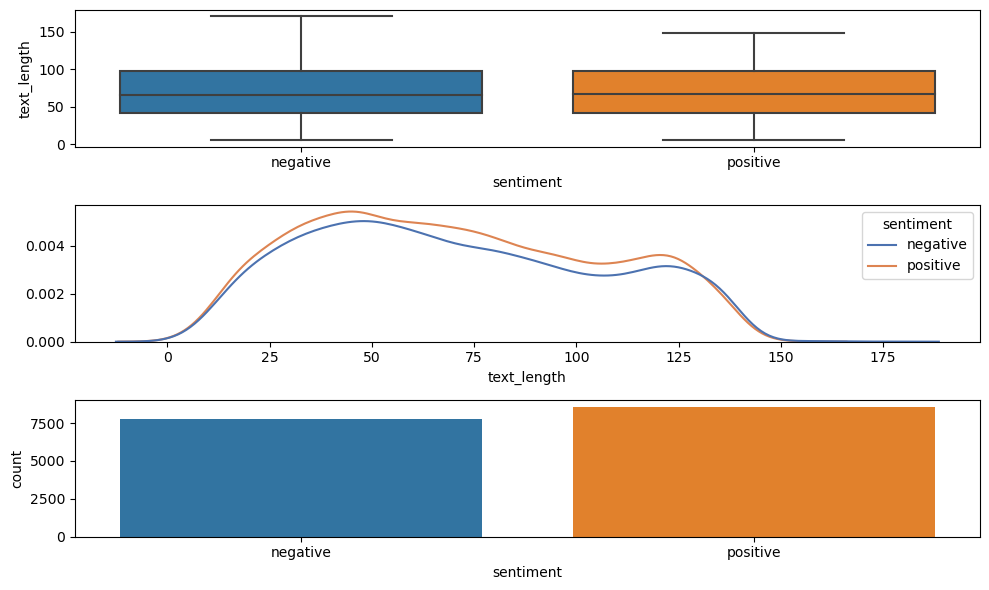

In [120]:
py.figure(figsize=(10,6))
py.subplot(3, 1, 1)
boxplot(tweet_train)
py.subplot(3, 1, 2)
kdeplot(tweet_train)
py.subplot(3, 1, 3)
countplot(tweet_train)
py.tight_layout()

          text_length                                                    
                count       mean        std  min   25%   50%   75%    max
sentiment                                                                
negative       1001.0  69.663337  34.898532  8.0  42.0  65.0  97.0  144.0
positive       1103.0  68.791478  34.772948  6.0  40.5  64.0  95.0  160.0


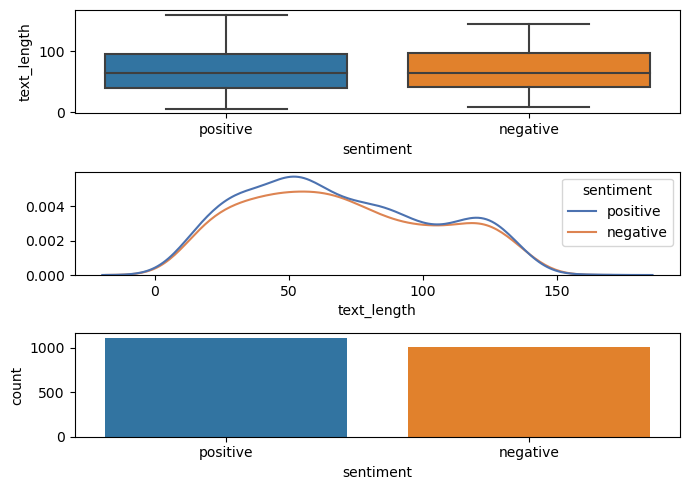

In [121]:
py.figure(figsize=(7,5))
py.subplot(3, 1, 1)
boxplot(tweet_test)
py.subplot(3, 1, 2)
kdeplot(tweet_test)
py.subplot(3, 1, 3)
countplot(tweet_test)
py.tight_layout()

In [122]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jdebn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [123]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jdebn\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [124]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jdebn\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [125]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\jdebn\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [126]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()

In [127]:
list = []

# TEXT CLEANING

In [128]:
def text_process(msg):
    
#     punc   = !"#$%&'()+,-./:;<=>?@[\]^_`{|}~
    nopunc = [c  for c in msg if c not in string.punctuation]
    nopunc = ''.join(nopunc)
#     print(nopunc)
    nopunc = re.sub(r"http\S+|www\S+|https\S+", "",nopunc)
    nopunc = ''.join(nopunc)
#     nopunc = re.sub(r'<[^<>]*>',"",''.join(nopunc))
    nopunc = re.sub(r'@[^\s]*','',nopunc)
    nopunc = ''.join(nopunc)
    nopunc = re.sub(r'[0-9]*','',nopunc)
#     nopunc = [m for m in nopunc if m.lower() not in stopwords.words('english')]
    nopunc = re.sub('[^a-zA-Z]',' ',nopunc)
    nopunc = ''.join(nopunc)
    
    return nopunc

In [136]:
tweet_train['text'] = tweet_train['text'].apply(text_process)                      

In [137]:
tweet_train.head()

,text,sentiment,text_length
0,Sooo SAD I will miss you here in San Diego,negative,46
1,my boss is bullying me,negative,25
2,what interview leave me alone,negative,31
3,Sons of why couldnt they put them on the rel...,negative,75
4,am feedings for the baby are fun when he is al...,positive,64


In [138]:
tweet_test['text'] = tweet_test['text'].apply(lambda x:text_process(str(x)))

In [139]:
tweet_test['text']

0        Shanghai is also really exciting precisely  s...
1       Recession hit Veronique Branquinho she has to ...
2                                              happy bday
3                                               I like it
4                               thats great weee visitors
                              ...                        
2099    its at  am im very tired but i cant sleep  but...
2100    All alone in this old house again  Thanks for ...
2101     I know what you mean My little dog is sinking...
2102    sutra what is your next youtube video gonna be...
2103                              omgssh  ang cute ng bby
Name: text, Length: 2104, dtype: object

# REMOVING STOPWORDS

In [140]:
def remove_stopwords(msg):
        STOPWORDS = set(stopwords.words('english'))
        return ' '.join([word for word in msg.split() if word.lower() not in stopwords.words('english')])

In [141]:
tweet_train['text'] = tweet_train['text'].apply(remove_stopwords)

In [142]:
tweet_test['text'] = tweet_test['text'].apply(remove_stopwords)

# REMOVE EMOJIS

In [148]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                                  u"\U0001F600-\U0001F64F"  # emoticons
                                  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                  u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                  u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                  u"\U00002702-\U000027B0"  # other miscellaneous symbols
                                  u"\U000024C2-\U0001F251"  # enclosed characters
                               "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)

In [149]:
tweet_test['text'] = tweet_test['text'].apply(remove_emoji)

In [150]:
tweet_train['text'] = tweet_train['text'].apply(remove_emoji)

# STEMMING

In [153]:
def stemmatize_words(text):
    stemmer = PorterStemmer()
    text_split = text.split()
    return " ".join([stemmer.stem(word) for word in text_split])

In [154]:
tweet_train['text'] = tweet_train['text'].apply(stemmatize_words)

In [155]:
tweet_test['text'] = tweet_test['text'].apply(stemmatize_words)

# LEMMATISATION

In [164]:
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    text_split = text.split()
    return " ".join([lemmatizer.lemmatize(word) for word in text_split])

In [165]:
tweet_test.text = tweet_test.text.apply(lemmatize_words)

In [166]:
tweet_train['text'] = tweet_train['text'].apply(lemmatize_words)


In [172]:
lemmatizer.lemmatize('responded')

'responded'

In [173]:
tweet_train.text

0                                  sooo sad miss san diego
1                                                bos bulli
2                                      interview leav alon
3                    son couldnt put releas alreadi bought
4                                  feed babi fun smile coo
                               ...                        
16358                                       enjoy ur night
16359    wish could come see u denver husband lost job ...
16360    ive wonder rake client made clear net dont for...
16361    yay good enjoy break probabl need hectic weeke...
16362                                                worth
Name: text, Length: 16363, dtype: object

In [174]:
tweet_test['text']

0       shanghai also realli excit precis skyscrap gal...
1       recess hit veroniqu branquinho quit compani shame
2                                              happi bday
3                                                    like
4                                 that great weee visitor
                              ...                        
2099                               im tire cant sleep tri
2100    alon old hous thank net keep aliv kick whoever...
2101    know mean littl dog sink depress want move som...
2102             sutra next youtub video gonna love video
2103                               omgssh ang cute ng bbi
Name: text, Length: 2104, dtype: object

In [175]:
def cleanData(text):

    ReapeatTokensRm =  " ".join( [ re.sub(r'(\w)\1{2,}', r'\1', word) for word in text.split()] )  # Remove repeating characters from tokens

    digitTokensRm =  " ".join( [ word for word in ReapeatTokensRm.split() if not re.search(r'\d', word) ] ) # Remove tokens containing digits

    underscoreTokensRm =  " ".join( [ word for word in digitTokensRm.split() if not re.search(r'_|\w*_\w*', word) ] ) # Remove tokens containing underscore

    specialTokensRm =  " ".join( [ word for word in underscoreTokensRm.split() if not re.search(r'[^a-zA-Z0-9\s]', word) ] ) # Remove tokens containing Special Characters

    return " ".join( [ word for word in specialTokensRm.split() if len(word) > 2 ] )  # Remove tokens less than 2 characters


tweet_train['text'] = tweet_train['text'].apply(cleanData)

In [176]:
tweet_test['text'] = tweet_test['text'].apply(cleanData)

# TFIDF

In [193]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [194]:
tfidf = TfidfVectorizer(use_idf=True,norm='l2',smooth_idf=True,max_df=0.7)

In [195]:
TrainedDataVectorised = tfidf.fit_transform(tweet_train['text'])

In [196]:
TrainedDataVectorised

<16363x14380 sparse matrix of type '<class 'numpy.float64'>'
	with 110268 stored elements in Compressed Sparse Row format>

In [197]:
TestedDataVectorised = tfidf.transform(tweet_test['text'])

In [198]:
TestedDataVectorised

<2104x14380 sparse matrix of type '<class 'numpy.float64'>'
	with 12822 stored elements in Compressed Sparse Row format>

In [659]:
feat_names = tfidf.get_feature_names()

C:\Users\jdebn\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [660]:
tfidf_df = p.DataFrame(TrainedDataVectorised.toarray(),columns=feat_names)

In [661]:
tfidf_df.columns

Index(['aah', 'aapko', 'aargh', 'aaron', 'aarrgghh', 'aasman', 'aba', 'abalon',
       'abandon', 'abang',
       ...
       'zoningconcept', 'zoo', 'zorni', 'zorzpeep', 'zotz', 'zuccini', 'zulu',
       'zumba', 'zune', 'zyrtec'],
      dtype='object', length=14380)

In [662]:
TrainedDataVectorised.toarray().shape

(16363, 14380)

In [663]:
tfidf_df.head()

,aah,aapko,aargh,aaron,aarrgghh,aasman,aba,abalon,abandon,abang,...,zoningconcept,zoo,zorni,zorzpeep,zotz,zuccini,zulu,zumba,zune,zyrtec
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [664]:
tfidf_df.isna().sum().unique()

array([0], dtype=int64)

# DATA SPLITTING

In [200]:
X_train = TrainedDataVectorised
X_test = TestedDataVectorised
y_train = tweet_train['sentiment']
y_test = tweet_test['sentiment']

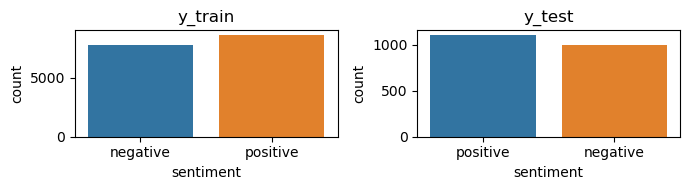

In [214]:
py.figure(figsize=(7,2))
py.subplot(1,2,1)
py.title('y_train')
s.countplot(x=y_train)
py.subplot(1,2,2)
py.title('y_test')
s.countplot(x=y_test)
py.tight_layout()

In [671]:
X_train.shape , X_test.shape , y_train.shape, y_test.shape

((16363, 14380), (2104, 14380), (16363,), (2104,))

In [672]:
X_train

<16363x14380 sparse matrix of type '<class 'numpy.float64'>'
	with 110268 stored elements in Compressed Sparse Row format>

In [673]:
from sklearn.utils import compute_class_weight

classWeights = compute_class_weight("balanced", classes = n.unique(y_train),
                                     y = y_train)

classWeights = dict(zip(n.unique(y_train), classWeights))

print(classWeights)

{'negative': 1.0514715332219509, 'positive': 0.9533325565136331}


In [674]:
from sklearn.utils import compute_class_weight

classWeights = compute_class_weight("balanced", classes = n.unique(y_test),
                                     y = y_test)

classWeights = dict(zip(n.unique(y_test), classWeights))

print(classWeights)

{'negative': 1.050949050949051, 'positive': 0.9537624660018132}


In [679]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,recall_score,precision_score,roc_auc_score

# MODEL TRAINING

In [680]:
rf_params = {'max_depth': [5, 8, 15,10,None],
            'min_samples_split': [2, 8, 15, 20,30],
             'max_features' : [5,7,'auto',8,10],
            'n_estimators': [100, 200, 300,400,500]}

In [681]:
randcv_model = [("RF",RandomForestClassifier(),rf_params)]

In [682]:
from sklearn.model_selection import RandomizedSearchCV

In [683]:
model_param = {}
for name, model, params in randcv_model:
    random = RandomizedSearchCV(estimator=model,
                               param_distributions=params,
                               n_iter=150,
                               cv=3,
                               verbose=2,
                               n_jobs=-1)
    random.fit(X_train,y_train)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


In [684]:
random.best_params_

{'n_estimators': 400,
 'min_samples_split': 30,
 'max_features': 10,
 'max_depth': None}

In [685]:
rf = RandomForestClassifier(class_weight=classWeights,n_estimators=400,max_features=10, min_samples_split = 30, max_depth = None)

In [686]:
rf.fit(X_train,y_train)

RandomForestClassifier(class_weight={'negative': 1.050949050949051,
                                     'positive': 0.9537624660018132},
                       max_features=10, min_samples_split=30, n_estimators=400)

In [687]:
pred = rf.predict(X_test)
print(model)
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

RandomForestClassifier()
[[901 100]
 [122 981]]


              precision    recall  f1-score   support

    negative       0.88      0.90      0.89      1001
    positive       0.91      0.89      0.90      1103

    accuracy                           0.89      2104
   macro avg       0.89      0.89      0.89      2104
weighted avg       0.89      0.89      0.89      2104



In [688]:
conf_mat = confusion_matrix(y_test,pred)

<AxesSubplot:>

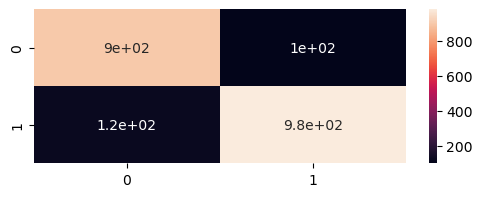

In [861]:
py.figure(figsize=(6,2))
s.heatmap(conf_mat,annot=True)

# SAVING MODEL

In [3]:
import pickle

In [2]:
saved_model = open('shreyaa_model.h5','wb')
pickle.dump(rf,saved_model)
saved_model.close()

NameError: name 'pickle' is not defined

In [693]:
filename = 'shreyaa_model.sav'
saved_rf = pickle.load(open(filename,'rb'))
score_model = saved_rf.score(X_test,y_test)

In [694]:
print(f'Score of model : {int(round(score_model*100))}%')

Score of model : 89%
